In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Dropout,LSTM,GRU
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tabulate import tabulate
import seaborn as sns

In [33]:
df=pd.read_csv('https://raw.githubusercontent.com/CallMePo/Final-Project-PMA/master/KepRiau%202015%20-%202022.csv ')
df

,datetime,total_visitor,total_accomodation
0,1/1/2014,164430,10055
1,2/1/2014,137055,10079
2,3/1/2014,167030,10132
3,4/1/2014,151982,10190
4,5/1/2014,154299,10274
...,...,...,...
103,8/1/2022,79470,15449
104,9/1/2022,104652,15502
105,10/1/2022,106160,15525
106,11/1/2022,103940,15612


In [34]:
df.isna().sum()

datetime              0
total_visitor         0
total_accomodation    0
dtype: int64

In [35]:
train_datetime=pd.to_datetime(df['datetime'])
train_datetime

0     2014-01-01
1     2014-02-01
2     2014-03-01
3     2014-04-01
4     2014-05-01
         ...    
103   2022-08-01
104   2022-09-01
105   2022-10-01
106   2022-11-01
107   2022-12-01
Name: datetime, Length: 108, dtype: datetime64[ns]

In [36]:
selected_columns = ['total_visitor','total_accomodation']
data_train = df.loc[:, selected_columns].astype(float)

In [37]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_train)

In [38]:
n_future=1
n_step=12

X_train=[]
y_train=[]
for i in range (n_step, len(data_scaled)-n_future+1):
    past_data = data_scaled[i-n_step:i, 0:data_scaled.shape[1]]
    future_data=data_scaled[i+n_future - 1:i +n_future,0]
    
    X_train.append(past_data)
    y_train.append(future_data)

X_train=np.array(X_train)
y_train=np.array(y_train)

TEST SIZE 80:20

In [39]:
X_train, X_test, y_train, y_test=train_test_split(X_train,y_train, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(76, 12, 2)
(76, 1)
(20, 12, 2)
(20, 1)


In [40]:
model=Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

In [41]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 256)               265216    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 265473 (1.01 MB)
Trainable params: 265473 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [43]:
early_stop=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history=model.fit(X_train,y_train, epochs=100, batch_size=32,validation_split=0.2, callbacks=[early_stop])

Epoch 1/100


2/2 [==============================] - 2s 352ms/step - loss: 0.2337 - val_loss: 0.0804
Epoch 2/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0835 - val_loss: 0.0464
Epoch 3/100
2/2 [==============================] - 0s 45ms/step - loss: 0.0761 - val_loss: 0.0358
Epoch 4/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0589 - val_loss: 0.0119
Epoch 5/100
2/2 [==============================] - 0s 48ms/step - loss: 0.0402 - val_loss: 0.0166
Epoch 6/100
2/2 [==============================] - 0s 48ms/step - loss: 0.0433 - val_loss: 0.0234
Epoch 7/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0464 - val_loss: 0.0175
Epoch 8/100
2/2 [==============================] - 0s 45ms/step - loss: 0.0403 - val_loss: 0.0091
Epoch 9/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0339 - val_loss: 0.0071
Epoch 10/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0354 - val_loss: 0.0065
Epoch 11/100
2/2 [============

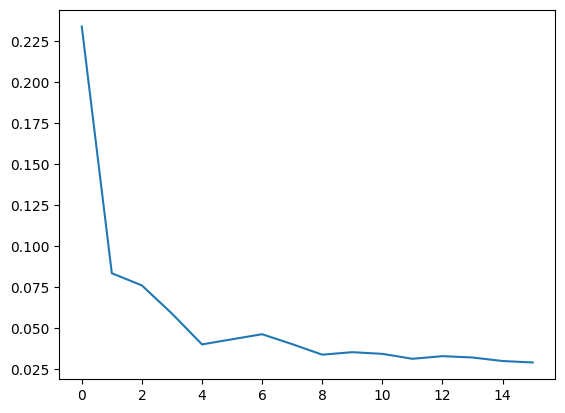

In [44]:
plt.plot(history.history['loss'])

In [45]:
n_past=1
n_pred=12
last_date=list(train_datetime)[-n_past]

predict_12=pd.date_range(last_date, periods=n_pred, freq='M').tolist()
print(predict_12)

[Timestamp('2022-12-31 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-28 00:00:00'), Timestamp('2023-03-31 00:00:00'), Timestamp('2023-04-30 00:00:00'), Timestamp('2023-05-31 00:00:00'), Timestamp('2023-06-30 00:00:00'), Timestamp('2023-07-31 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-09-30 00:00:00'), Timestamp('2023-10-31 00:00:00'), Timestamp('2023-11-30 00:00:00')]


In [46]:
from sklearn.metrics import mean_absolute_error

prediction=model.predict(X_test[-n_pred:])

mse=mean_squared_error(y_test[-n_pred:],prediction)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(y_test[-n_pred:],prediction)
mae=mean_absolute_error(y_test[-n_pred:], prediction)

print("mse:",mse)
print("rmse",rmse)
print("MAPE:", f"{mape:.2f}%")
print("mae",mae)

1/1 [==============================] - 0s 423ms/step
mse: 0.027503634345740765
rmse 0.16584219712045775
MAPE: 16.31%
mae 0.09982970817931414


In [47]:
prediction_copy = np.repeat(prediction, data_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copy)[:, 0]

C:\Users\atrke\AppData\Local\Temp\ipykernel_10168\1499544800.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['datetime']=pd.to_datetime(actual['datetime'])
c:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\atrke\AppD

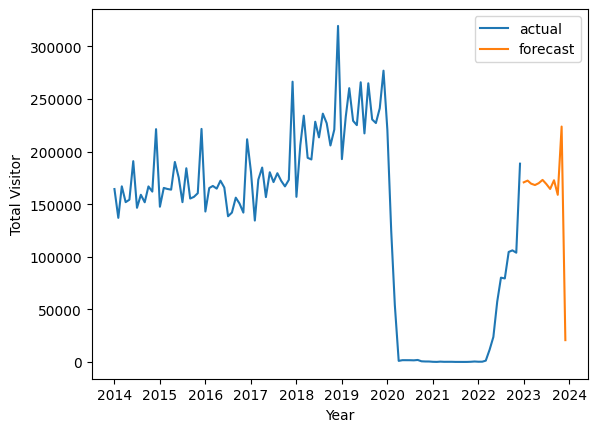

In [48]:
forecast_dates=[]
for i in predict_12:
    forecast_dates.append(i.date())
    
df_forecast=pd.DataFrame({'Date': forecast_dates,'total_visitor':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

actual=df[['datetime','total_visitor']]
actual['datetime']=pd.to_datetime(actual['datetime'])
actual=actual.loc[actual['datetime']>='2013-01-01']

sns.lineplot(actual, x='datetime', y='total_visitor',label='actual')
sns.lineplot(df_forecast,x='Date',y='total_visitor',label='forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


In [49]:
forecast_dates_1=pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

data=list(zip(forecast_dates_1,y_pred_future))

headers=['Date','Prediction']
table=tabulate(data, headers=headers, tablefmt='fancy_grid')
print(table)

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │     170818   │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │     172451   │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │     169545   │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │     168231   │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │     169999   │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │     173111   │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │     169229   │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │     164512   │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │     172781   │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │     158968   │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │     223817   │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

TRAIN TEST SIZE 70:30

In [50]:
X_train, X_test, y_train, y_test=train_test_split(X_train,y_train, test_size=0.3, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(53, 12, 2)
(53, 1)
(23, 12, 2)
(23, 1)


In [51]:
model=Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

In [52]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 256)               265216    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 265473 (1.01 MB)
Trainable params: 265473 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
early_stop=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history=model.fit(X_train,y_train, epochs=100, batch_size=32,validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
2/2 [==============================] - 3s 625ms/step - loss: 0.2603 - val_loss: 0.0783
Epoch 2/100
2/2 [==============================] - 0s 68ms/step - loss: 0.0796 - val_loss: 0.0467
Epoch 3/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0787 - val_loss: 0.0553
Epoch 4/100
2/2 [==============================] - 0s 54ms/step - loss: 0.0712 - val_loss: 0.0183
Epoch 5/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0309 - val_loss: 0.0204
Epoch 6/100
2/2 [==============================] - 0s 51ms/step - loss: 0.0391 - val_loss: 0.0283
Epoch 7/100
2/2 [==============================] - 0s 44ms/step - loss: 0.0446 - val_loss: 0.0264
Epoch 8/100
2/2 [==============================] - 0s 29ms/step - loss: 0.0462 - val_loss: 0.0188
Epoch 9/100
2/2 [==============================] - 0s 73ms/step - loss: 0.0336 - val_loss: 0.0135
Epoch 10/100
2/2 [==============================] - 0s 44ms/step - loss: 0.0293 - val_loss: 0.0143
Epoch 11/100
2/2 [

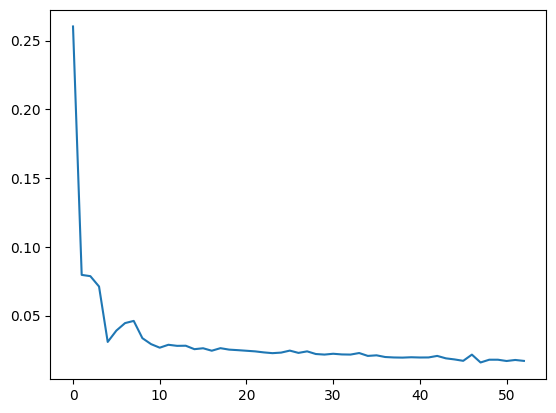

In [55]:
plt.plot(history.history['loss'])

In [56]:
n_past=1
n_pred=12
last_date=list(train_datetime)[-n_past]

predict_12=pd.date_range(last_date, periods=n_pred, freq='M').tolist()
print(predict_12)

[Timestamp('2022-12-31 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-28 00:00:00'), Timestamp('2023-03-31 00:00:00'), Timestamp('2023-04-30 00:00:00'), Timestamp('2023-05-31 00:00:00'), Timestamp('2023-06-30 00:00:00'), Timestamp('2023-07-31 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-09-30 00:00:00'), Timestamp('2023-10-31 00:00:00'), Timestamp('2023-11-30 00:00:00')]


In [57]:
from sklearn.metrics import mean_absolute_error

prediction=model.predict(X_test[-n_pred:])

mse=mean_squared_error(y_test[-n_pred:],prediction)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(y_test[-n_pred:],prediction)
mae=mean_absolute_error(y_test[-n_pred:], prediction)

print("mse:",mse)
print("rmse",rmse)
print("MAPE:", f"{mape:.2f}%")
print("mae",mae)

1/1 [==============================] - 0s 344ms/step
mse: 0.02195770156959739
rmse 0.14818131315924216
MAPE: 165.28%
mae 0.09870422478661285


In [58]:
prediction_copy = np.repeat(prediction, data_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copy)[:, 0]

C:\Users\atrke\AppData\Local\Temp\ipykernel_10168\1499544800.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['datetime']=pd.to_datetime(actual['datetime'])
c:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\atrke\AppD

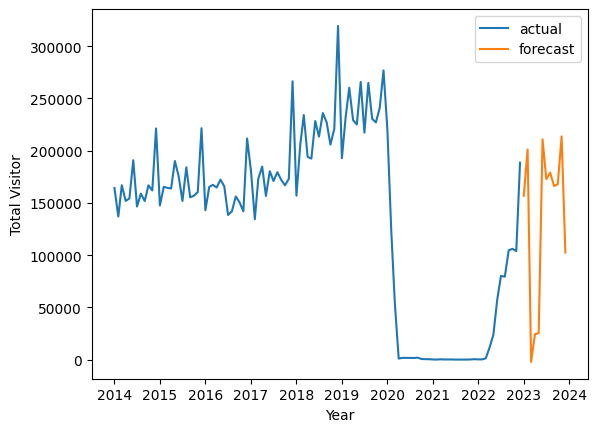

In [59]:
forecast_dates=[]
for i in predict_12:
    forecast_dates.append(i.date())
    
df_forecast=pd.DataFrame({'Date': forecast_dates,'total_visitor':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

actual=df[['datetime','total_visitor']]
actual['datetime']=pd.to_datetime(actual['datetime'])
actual=actual.loc[actual['datetime']>='2013-01-01']

sns.lineplot(actual, x='datetime', y='total_visitor',label='actual')
sns.lineplot(df_forecast,x='Date',y='total_visitor',label='forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


In [60]:
forecast_dates_1=pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

data=list(zip(forecast_dates_1,y_pred_future))

headers=['Date','Prediction']
table=tabulate(data, headers=headers, tablefmt='fancy_grid')
print(table)

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │    156907    │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │    201205    │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │     -2081.17 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │     24428.4  │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │     25418.5  │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │    210948    │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │    172842    │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │    179097    │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │    166240    │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │    167913    │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │    213700    │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

TRAIN TEST SIZE 60:40

In [61]:
X_train, X_test, y_train, y_test=train_test_split(X_train,y_train, test_size=0.4, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(31, 12, 2)
(31, 1)
(22, 12, 2)
(22, 1)


In [62]:
model=Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

In [63]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 256)               265216    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 265473 (1.01 MB)
Trainable params: 265473 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [65]:
early_stop=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history=model.fit(X_train,y_train, epochs=100, batch_size=32,validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2732 - val_loss: 0.1598
Epoch 2/100
1/1 [==============================] - 0s 50ms/step - loss: 0.1575 - val_loss: 0.0833
Epoch 3/100
1/1 [==============================] - 0s 56ms/step - loss: 0.0842 - val_loss: 0.0343
Epoch 4/100
1/1 [==============================] - 0s 77ms/step - loss: 0.0497 - val_loss: 0.0178
Epoch 5/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0568 - val_loss: 0.0195
Epoch 6/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0731 - val_loss: 0.0155
Epoch 7/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0609 - val_loss: 0.0097
Epoch 8/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0480 - val_loss: 0.0078
Epoch 9/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0346 - val_loss: 0.0102
Epoch 10/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0317 - val_loss: 0.0143
Epoch 11/100
1/1 [===

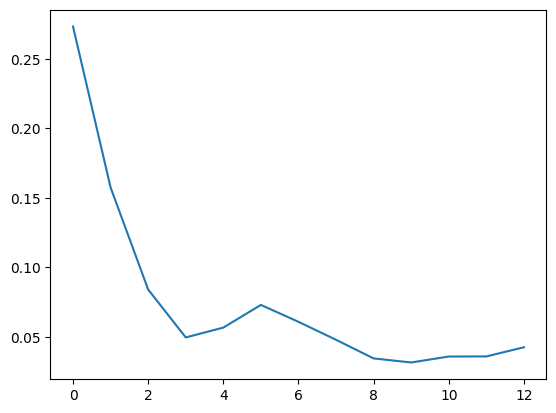

In [66]:
plt.plot(history.history['loss'])

In [67]:
n_past=1
n_pred=12
last_date=list(train_datetime)[-n_past]

predict_12=pd.date_range(last_date, periods=n_pred, freq='M').tolist()
print(predict_12)

[Timestamp('2022-12-31 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-28 00:00:00'), Timestamp('2023-03-31 00:00:00'), Timestamp('2023-04-30 00:00:00'), Timestamp('2023-05-31 00:00:00'), Timestamp('2023-06-30 00:00:00'), Timestamp('2023-07-31 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-09-30 00:00:00'), Timestamp('2023-10-31 00:00:00'), Timestamp('2023-11-30 00:00:00')]


In [68]:
from sklearn.metrics import mean_absolute_error

prediction=model.predict(X_test[-n_pred:])

mse=mean_squared_error(y_test[-n_pred:],prediction)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(y_test[-n_pred:],prediction)
mae=mean_absolute_error(y_test[-n_pred:], prediction)

print("mse:",mse)
print("rmse",rmse)
print("MAPE:", f"{mape:.2f}%")
print("mae",mae)

1/1 [==============================] - 0s 349ms/step
mse: 0.03517415784112333
rmse 0.1875477481632966
MAPE: 20.18%
mae 0.14719318879682944


In [69]:
prediction_copy = np.repeat(prediction, data_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copy)[:, 0]

C:\Users\atrke\AppData\Local\Temp\ipykernel_10168\1499544800.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['datetime']=pd.to_datetime(actual['datetime'])
c:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\atrke\AppD

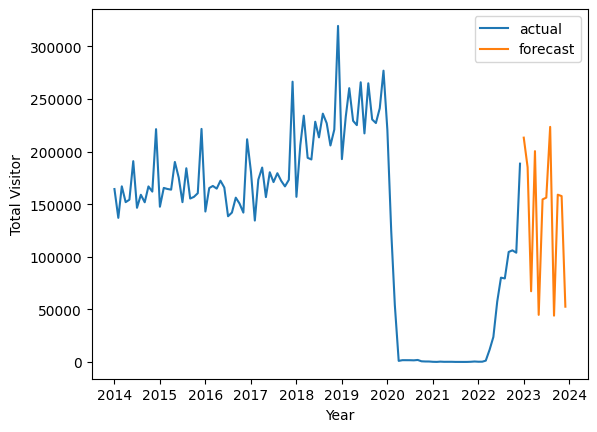

In [70]:
forecast_dates=[]
for i in predict_12:
    forecast_dates.append(i.date())
    
df_forecast=pd.DataFrame({'Date': forecast_dates,'total_visitor':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

actual=df[['datetime','total_visitor']]
actual['datetime']=pd.to_datetime(actual['datetime'])
actual=actual.loc[actual['datetime']>='2013-01-01']

sns.lineplot(actual, x='datetime', y='total_visitor',label='actual')
sns.lineplot(df_forecast,x='Date',y='total_visitor',label='forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


In [71]:
forecast_dates_1=pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

data=list(zip(forecast_dates_1,y_pred_future))

headers=['Date','Prediction']
table=tabulate(data, headers=headers, tablefmt='fancy_grid')
print(table)

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │     213279   │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │     185160   │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │      67297.4 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │     200449   │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │      44868.8 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │     154576   │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │     156302   │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │     223514   │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │      44120.1 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │     159051   │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │     157735   │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  